In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

# Monte Carlo Motivation #
Typically we will have some probability distribution $P(x) = \frac{P^*(x)}{Z}$ that we are interested in computing (x is the parameters) 
but the _partition function_ (Z) is intractable. 
In these situations we can typically calculate P* , we don't know Z but it would be of interest if we could find it out (model comparison for ex)

Typically when you are looking to find a posterior distribution, the numerator is P* and tractable, but the denominator i.e. the normalizing constant 
is a complicated multi-dimensional integral that we don't know. 

More precisely, we can define $P^*(x)$ as $e^-{E(x)}$ where we can evaluate $E(x)$ at any point. 
We are typically then interested in:
1) Draw samples from P (**sampling parameters for the true dist given data)
2) Estimate expectations of functions under P $\phi = \sum_x \phi(x)P(x)$

For example, if we want to know how probable it is that the distributions mean is in some range, we can use the posterior probabilities of the means 
and then average the function that is 1 if x in range or 0 otherwise. 

### Importance Sampling & Rejection Sampling ### 
Many MC methods need __Proposal Densities__  $Q$ which is some density that we _can_ sample from. 
Assume we have a function phi(x) and we want to know the expectation of it under our unnormalized dist P*(x)

How can we do this? One idea is to sample x from $Q$ and then calculate $\phi(x)$ at each of these points and average them. 
This would give us  $\phi(x)$ under $Q$ which is not what we want, but if we weight each point by $\frac{P^*(x)}{Q(x)}$ (and adjust our normalizing constant) then we are essentially 
upweighting points where $P*$ is more likely than $Q$ and vice versa. This is technique is known as __Importance Sampling__

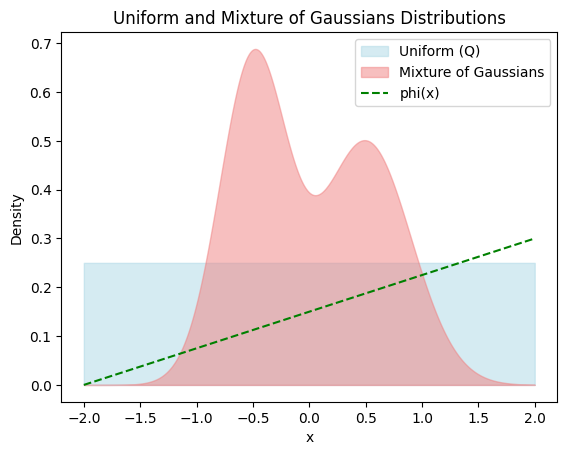

In [7]:


# Define the x-axis values
x = np.linspace(-2, 2, 1000)

# Define the parameters for the two Gaussian distributions
mean1 = -0.5
std1 = 0.3
mean2 = 0.5
std2 = 0.4

# Create the mixture of two Gaussian distributions
gaussian1 = stats.norm.pdf(x, mean1, std1)
gaussian2 = stats.norm.pdf(x, mean2, std2)
mixture = 0.5 * gaussian1 + 0.5 * gaussian2

# Plot the uniform distribution in light blue
plt.fill_between(x, stats.uniform.pdf(x, loc=-2, scale=4), color='lightblue', alpha=0.5, label='Uniform (Q)')

# Plot the mixture of two Gaussian distributions in opaque light red
plt.fill_between(x, mixture, color='lightcoral', alpha=0.5, label='Mixture of Gaussians')
plt.plot([-2, 2], [0, 0.3], color='green', linestyle='--', label='phi(x)')

# Add labels and a legend
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Uniform and Mixture of Gaussians Distributions')
plt.legend()

plt.show()  # Display the plot

### Issues with Importance Sampling ### 
If not obvious from above, this method can run into problems when your proposal distribution $Q$ 
does not look like your target distribution $P*$, and of course a priori we have no idea what $P*$ looks like! 

For example, if you have $Q$ very close to zero, and $P*$ >> 0 then the weight assigned to that point can be massive
and cause spikes in your estimate of expected value of $\phi(x)$. Additionally, during this whole process we never know
__when__ we are close or far away from the true mean, even if we are guaranteed some sort of asymptotic convergence. 

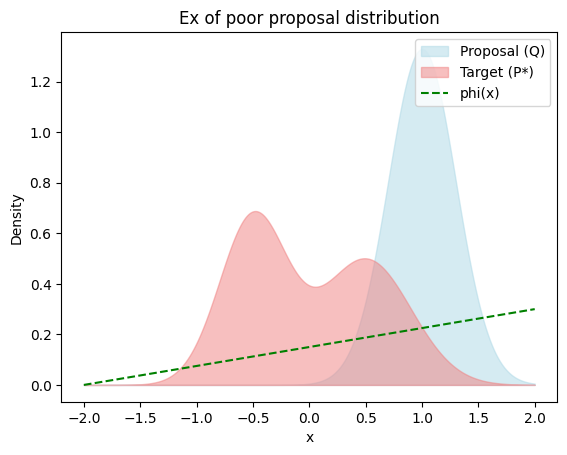

In [12]:
x = np.linspace(-2, 2, 1000)

# Define the parameters for the two Gaussian distributions
mean1 = -0.5
std1 = 0.3
mean2 = 0.5
std2 = 0.4

# Create the mixture of two Gaussian distributions
gaussian1 = stats.norm.pdf(x, mean1, std1)
gaussian2 = stats.norm.pdf(x, mean2, std2)
P = 0.5 * gaussian1 + 0.5 * gaussian2
Q = stats.norm.pdf(x, 1, 0.3)


plt.fill_between(x, Q, color='lightblue', alpha=0.5, label='Proposal (Q)')
plt.fill_between(x, mixture, color='lightcoral', alpha=0.5, label='Target (P*)')
plt.plot([-2, 2], [0, 0.3], color='green', linestyle='--', label='phi(x)')

# Add labels and a legend
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Ex of poor proposal distribution')
plt.legend()

plt.show()  # Display the plot

### Rejection Sampling ### 
The thought process behind rejection sampling is that we have a proposal distribution again $Q(x)$, where we __know__
$cQ(x) > P^*(x) \text{ for some } C \in \mathbb{R}$ 

If we can find such a distribution (which might be hard to do) then we can follow the following steps to sample from $P*(x)$:
1. draw x' from $cQ(x)$
2. Draw from a uniform dist on [0, $cQ(x')$]
3. if u <= P*(x) then ACCEPT this point, otherwise REJECT the point 
4. Repeat

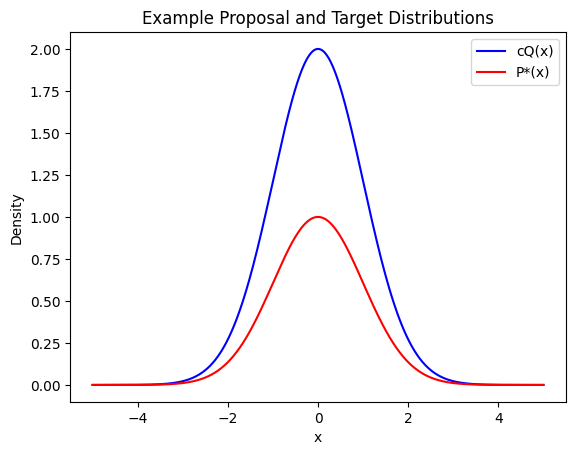

In [19]:
x = np.linspace(-5, 5, 1000)

# Define the two unnormalized distributions
cQ = 2 * np.exp(-0.5 * x**2)
P_star = np.exp(-0.5 * x **2)

# Plot the cQ(x) distribution in blue
plt.plot(x, cQ, color='blue', label='cQ(x)')

# Plot the P*(x) distribution in red
plt.plot(x, P_star, color='red', label='P*(x)')

# Add labels and a legend
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Example Proposal and Target Distributions')
plt.legend()

plt.show()  # Display the plot

### Problems with Rejection Sampling ### 
1. Obviously, it can be hard to arrive at a $cQ(x)$ that is guaranteed to be greater than $P^*(x)$ everywhere
2. even if you _do_ find such a distribution, your distribution needs to be reasonably 'tight' to $P^*(x)$. 
if you just pick some massive c, then you would reject many many points and your sampling might take quite a long time. 

**Aside: probability that a sample is accepted is a geometric r.v. with p = 1 / c, thus
the expected number of samples you have to draw to be accepted is c. Now you can see why we want to find 
the tightest bounded c possible to improve our efficiency! 

## Metropolis Methods and Gibbs Sampling ## 
These methods are examples of _Markov Chain Monte Carlo_ where we keep track of our 'state' by using the previous point
to move to the next. We will still have a proposal distribution that we can sample from, $Q(x ; x')$ but now x represents the next location
and x' represents the current location we are at. 

Importantly, the proposal distribution here does _not_ have to look like $P^*(x)$, which previously was very helpful for 
important sampling and rejection sampling. 

Typically for this method to work, Q will make just a small change to the energy of the system (e.g. $-\log{ P^*(x)}$)

The algorithm for this is as follows:
1. draw an x from $Q(x ; x')$
2. calculate our acceptance ratio: $a = \frac{P^*(x) * Q(x^t ; x)}{P^*(x^t) * Q(x, x^t)}$
    - $Q(x^t ; x)$ is the probability we return to x(t) from point x 
    - if $Q(x^t ; x)$  and $Q(x ; x^t)$  have different normalizing constants, then we need to know them. otherwise 
    they would cancel out 
 3. if a > 1; accept (e.g $x^{t+1}$ is $x$) or if a < 1 accept with probability a 
4. if we reject then x(t+1) = x(t) so we don't move 

Asymptotically, the probability distribution of x(t) is $P(x)$!! The high level intuition: where $P^*(x)$ is large, 
it will be very hard to draw points that higher than that, thus it is _likely_ that you will remain there for your next sample
instead of moving somewhere else on the curve. This forces you to draw more points in these locations, which would make sense if 
you are sampling from $P^*$! 

Let's implement an example: 

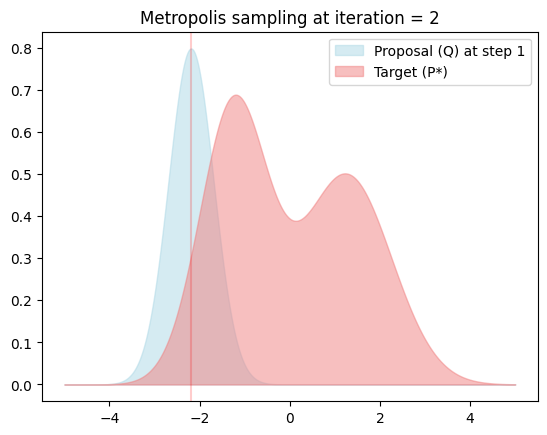

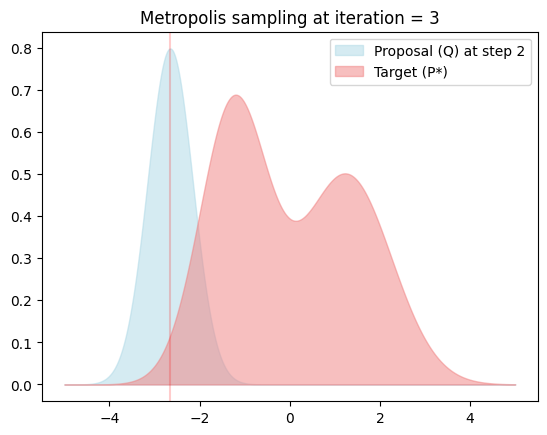

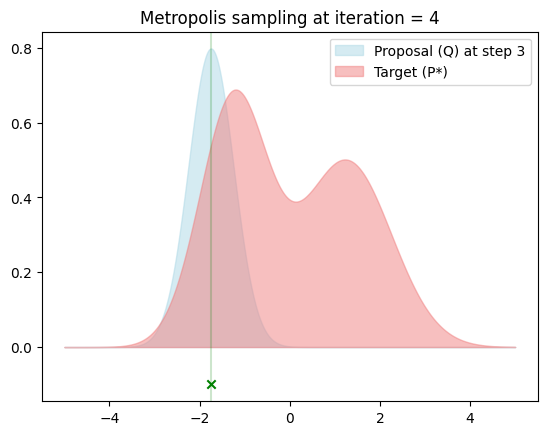

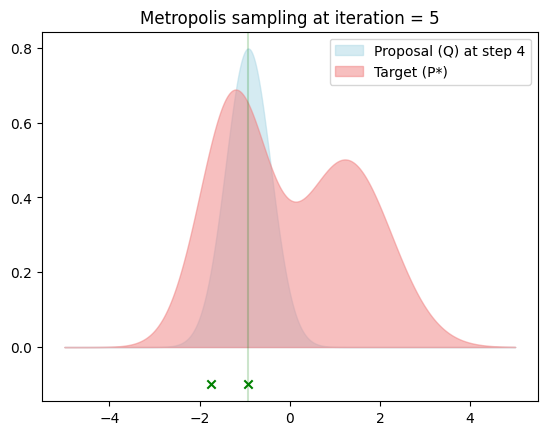

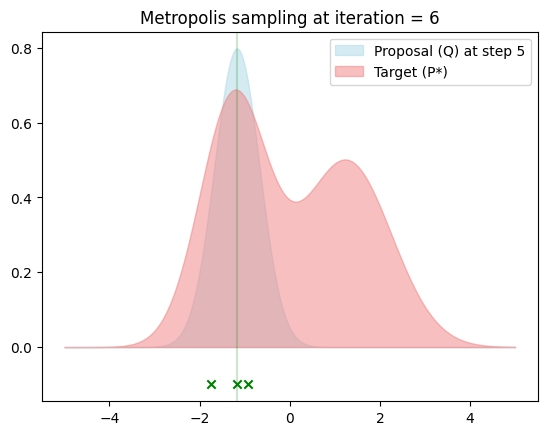

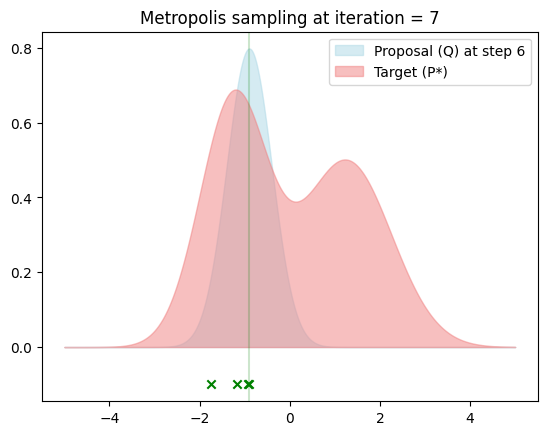

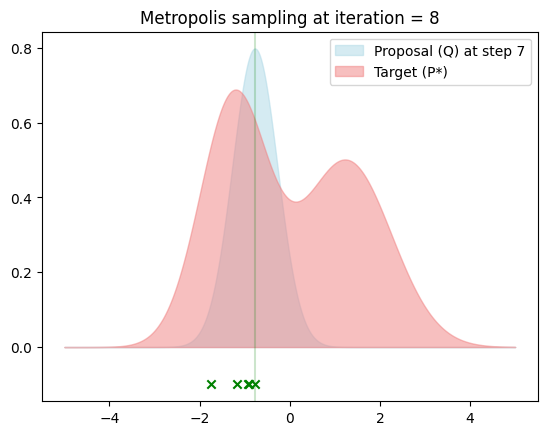

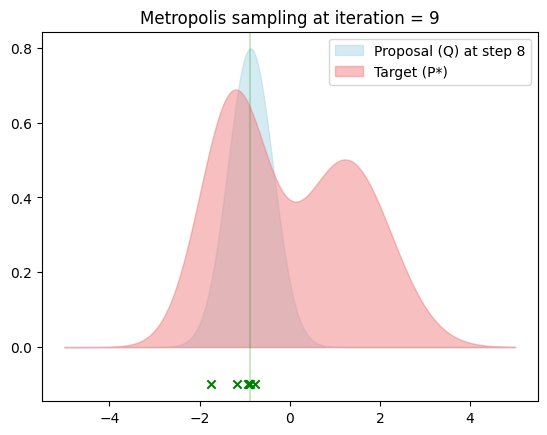

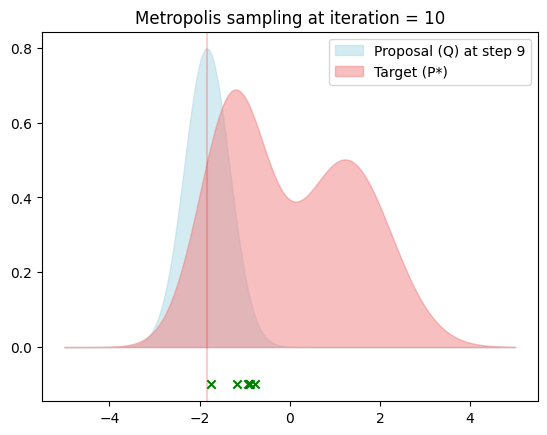

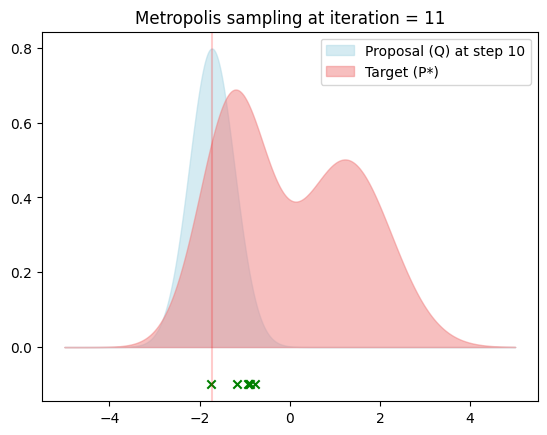

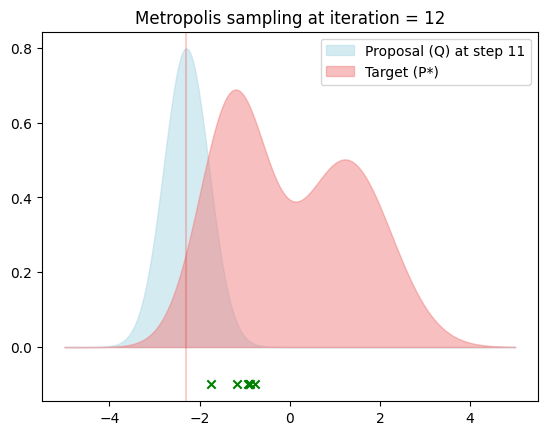

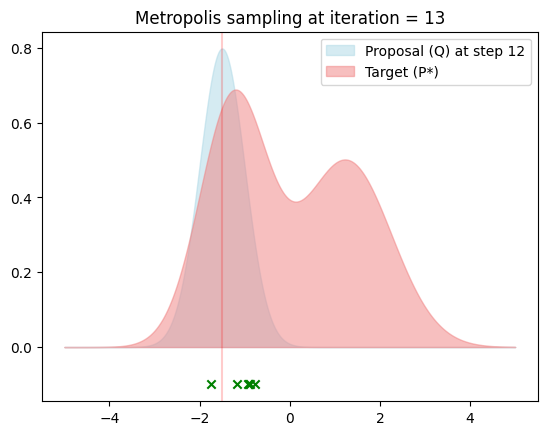

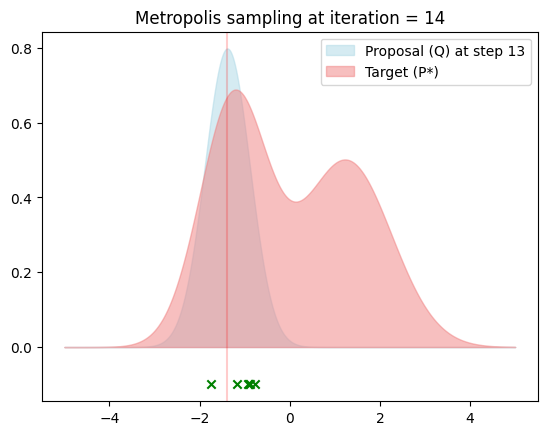

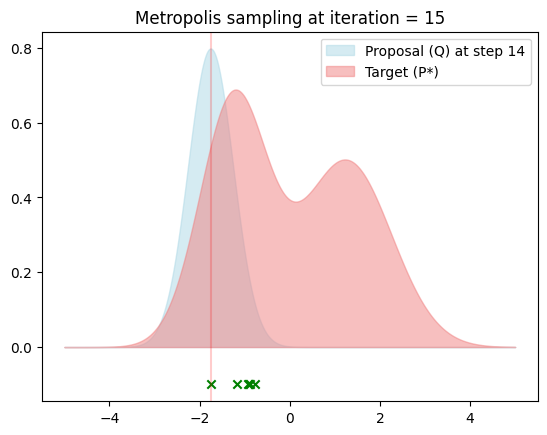

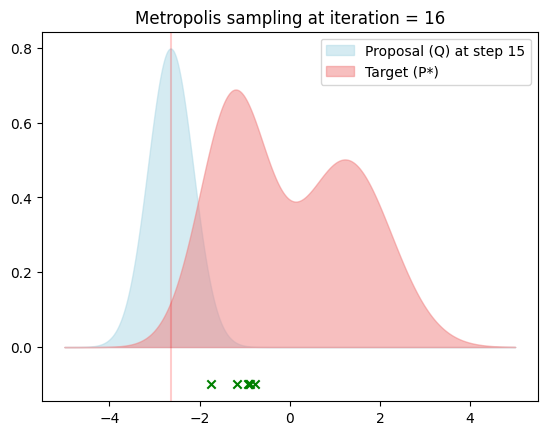

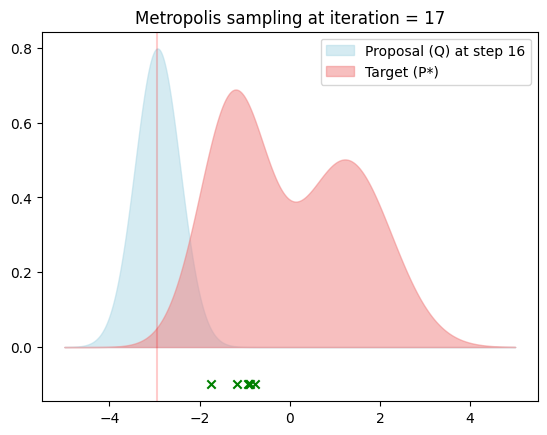

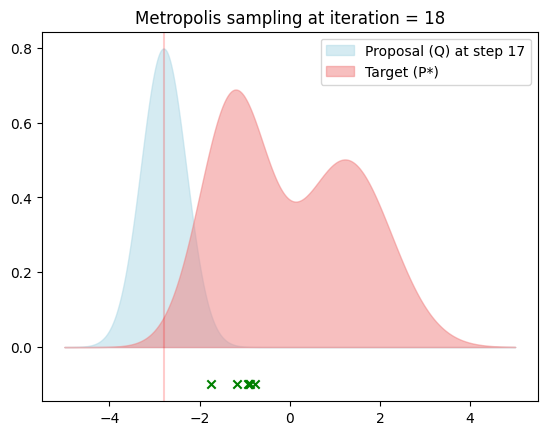

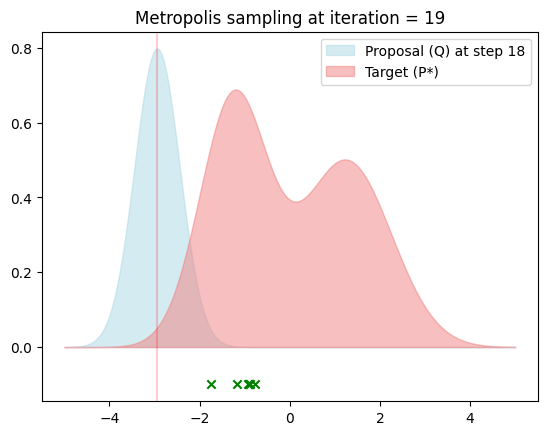

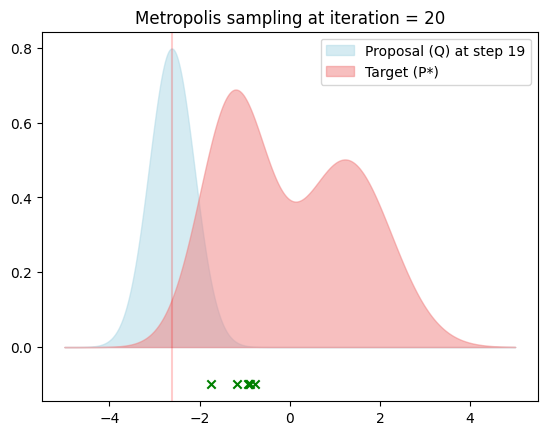

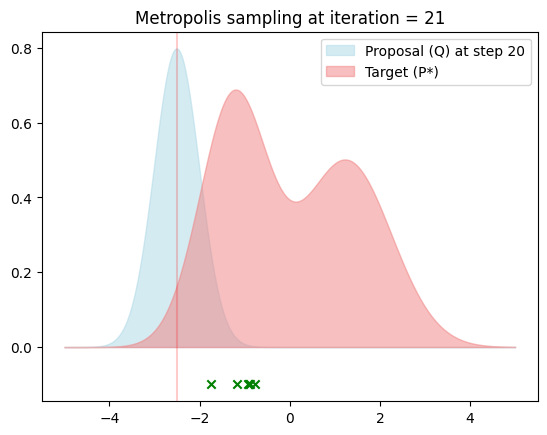

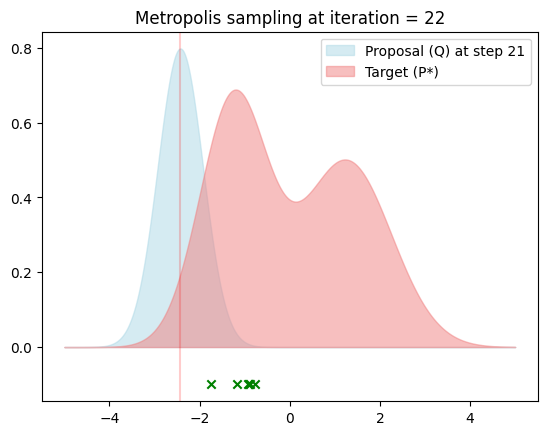

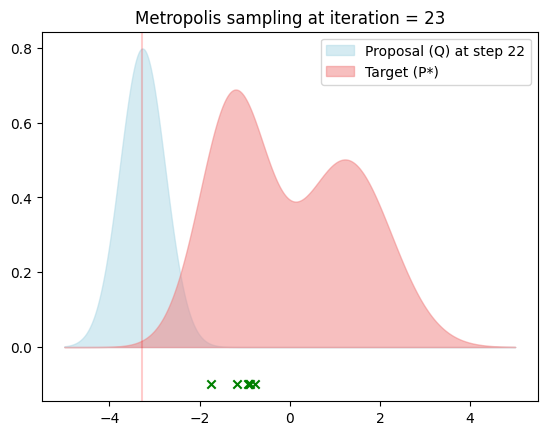

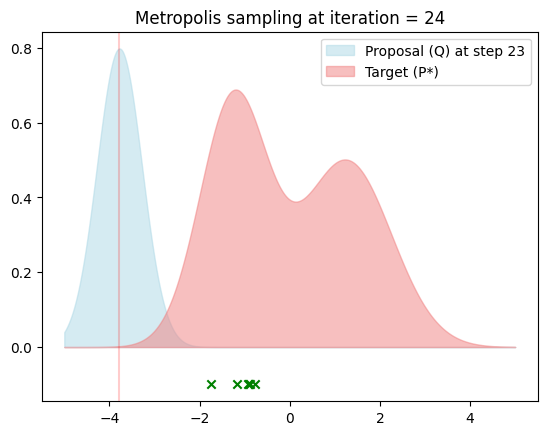

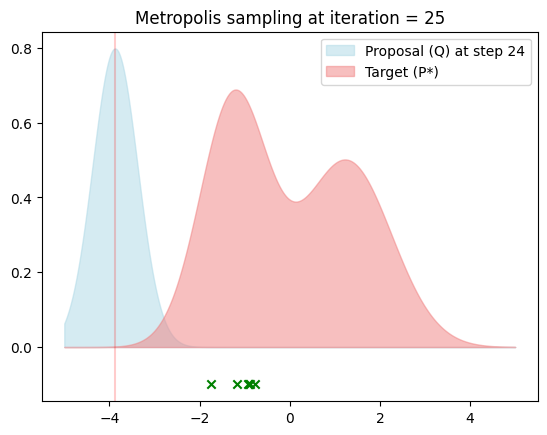

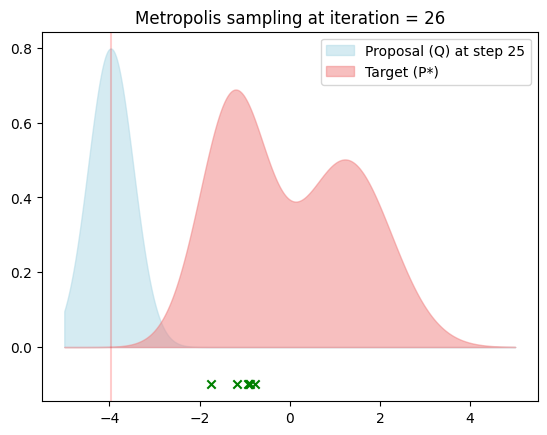

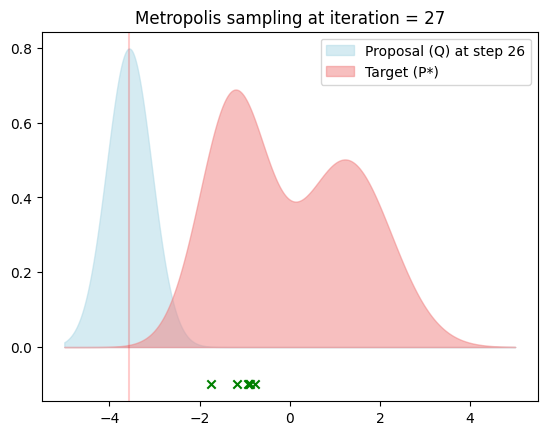

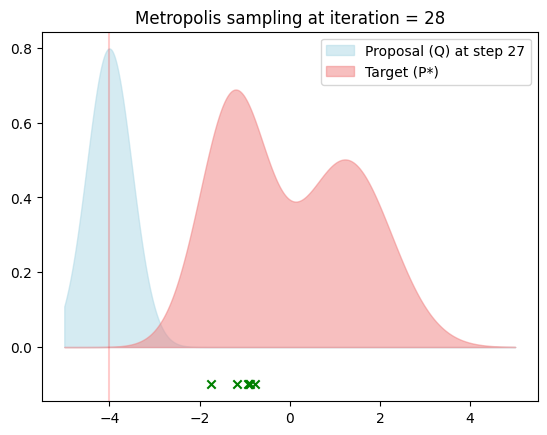

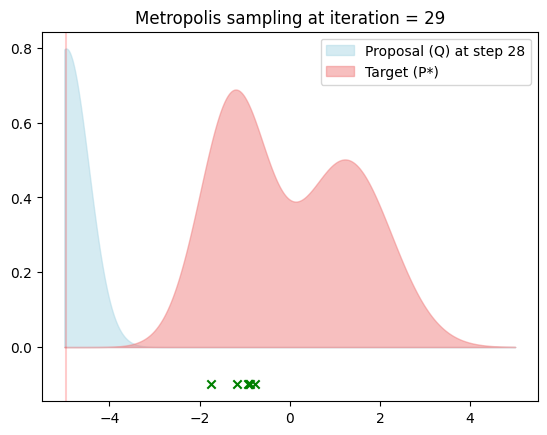

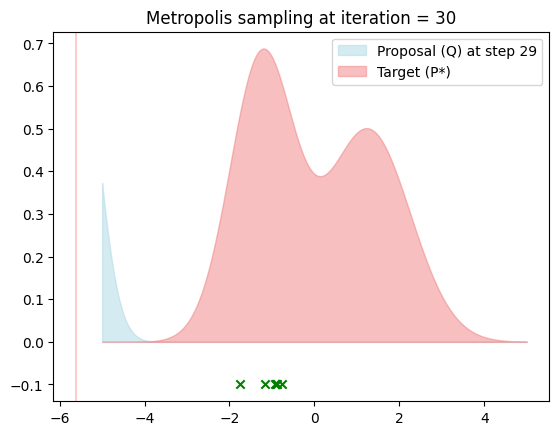

In [38]:
def evaluate_target(x):
    mean1, std1 = -0.5, 0.3
    mean2, std2 = 0.5, 0.4
    gaussian1 = stats.norm.pdf(x, mean1, std1)
    gaussian2 = stats.norm.pdf(x, mean2, std2)
    P = 0.5 * gaussian1 + 0.5 * gaussian2
    return P

x = np.linspace(-5, 5, 1000)
mean = np.random.uniform(-5, 5)
stdev = 0.5

# proposal dist 
Q = stats.norm.pdf(mean, stdev, 0.5)
# target dist 
P = evaluate_target(x)

plt.fill_between(x, Q, color='lightblue', alpha=0.5, label='Proposal (Q)')
plt.fill_between(x, P, color='lightcoral', alpha=0.5, label='Target (P*)')

accepted_points = []
P_old = evaluate_target(mean)
i = 1
while (len(accepted_points) < 10) and (i < 30):
    plt.clf()
    # sample from Q which will be the mean of the next proposal dist
    mean = np.random.normal(mean, stdev)
    P_new = evaluate_target(mean)
    # gaussians cancel out so just need to compare the ratio of the two P's 
    a = P_new / P_old
    if np.random.uniform() < a:  # will always accept a  > 1 
        P_old = P_new
        accepted_points.append(mean)
        plt.axvline(mean, color='green', alpha=0.2)
    else:
        plt.axvline(mean, color='red', alpha=0.2)
    
    Q = stats.norm.pdf(x, mean, stdev)
    plt.title(f"Metropolis sampling at iteration = {i+1}")
    plt.fill_between(x, Q, color='lightblue', alpha=0.5, label=f'Proposal (Q) at step {i}')
    plt.fill_between(x, mixture, color='lightcoral', alpha=0.5, label='Target (P*)')
    plt.scatter(accepted_points, np.full(len(accepted_points), -0.1), color='green', marker='x')  # Plot the accepted points
    plt.legend()
    plt.pause(0.5)
    i += 1 

plt.show()
   



### Problems with Metropolis Method ###
Once again, we know that asymptotically we are drawing from $P(x)$ but we don't know how long
we have to run this in order to get there. 

### Gibbs Sampling ### 
MCMC method that only makes sense when you have two dimensions. For Gibbs sampling, we still obviously cannot draw 
from $P(x)$ _but_ we make the rather large assumption we _can_ draw from a conditional distribution such as $P(x1 | x2)$ in a two dimensional case. 

Algorithm:
1. Starting at $x_1^{t}$, draw $x_1^{t+1}$ from $P(x_1 | x_2^{t})$
2. Then sample $x_2^{t+1}$ using $P(x_2 | x_1^{t+1})$ from step 1
3. Repeat - for k variables, you will need to sample conditional dist for each one 
given all the others. 

Gibbs is a metropolis method, so asymptotically it draws from the correct dist!

Let's implement a quick example, using Gibbs sampling to infer parameters for a gaussian distribution $\mu$ and $\sigma$